In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pathlib import Path

from plot import create_stacked_plot
from utils import calculate_comp_and_comm_time
sns.set_theme()

In [23]:
logs_dir = Path("logs")
ddp_path = logs_dir / "profile_ddp_4.csv"
deepspeed_path = logs_dir / "profile_deepspeed_4.csv"
horovod_path = logs_dir / "profile_horovod_4.csv"

ddp_df = pd.read_csv(ddp_path)
deepspeed_df = pd.read_csv(deepspeed_path)
horovod_df = pd.read_csv(horovod_path)

ddp_df["strategy"] = "ddp"
deepspeed_df["strategy"] = "deepspeed"
horovod_df["strategy"] = "horovod"

ddp_df["num_gpus"] = 4
deepspeed_df["num_gpus"] = 4
horovod_df["num_gpus"] = 4

total_df = pd.concat([ddp_df, deepspeed_df, horovod_df])

save_path = Path("logs/total_df.csv")
total_df.to_csv(save_path)

display(total_df.head())

,name,node_id,self_cpu_time_total,cpu_time_total,cpu_time_total_str,self_cuda_time_total,cuda_time_total,cuda_time_total_str,calls,strategy,num_gpus
0,record_param_comms,-1,968728,2647173,2.647s,21279206,22734017,22.734s,175,ddp,4
1,aten::to,-1,4467,1256098,1.256s,0,1088851,1.089s,2842,ddp,4
2,aten::_to_copy,-1,3762,1255212,1.255s,0,1089688,1.090s,958,ddp,4
3,aten::empty_strided,-1,31949,85716,85.716ms,0,19490,19.490ms,1443,ddp,4
4,cudaDeviceGetStreamPriorityRange,-1,168,168,168.000us,292381,292381,292.381ms,9289,ddp,4


In [32]:
deepspeed_df["self_cuda_time_total"].sum() / 1e6

23.223029

In [30]:
deepspeed_df = deepspeed_df.sort_values("cuda_time_total", ascending=False)
deepspeed_df.head(30)

,name,node_id,self_cpu_time_total,cpu_time_total,cpu_time_total_str,self_cuda_time_total,cuda_time_total,cuda_time_total_str,calls,strategy,num_gpus
150,autograd::engine::evaluate_function: Convoluti...,-1,101893,2010098,2.010s,0,4920481,4.920s,1860,deepspeed,4
152,aten::convolution_backward,-1,641714,1846661,1.847s,4307016,4614625,4.615s,1860,deepspeed,4
151,ConvolutionBackward0,-1,24361,1871022,1.871s,0,4614625,4.615s,1860,deepspeed,4
47,aten::convolution,-1,76436,2180105,2.180s,0,2309901,2.310s,1860,deepspeed,4
49,aten::cudnn_convolution,-1,1074307,2094488,2.094s,2047139,2309901,2.310s,1860,deepspeed,4
48,aten::_convolution,-1,9181,2103527,2.104s,0,2304478,2.304s,1860,deepspeed,4
46,aten::conv2d,-1,37516,2203642,2.204s,0,2196509,2.197s,1860,deepspeed,4
148,aten::cudnn_batch_norm_backward,-1,77335,343615,343.615ms,1072039,1148976,1.149s,1860,deepspeed,4
146,autograd::engine::evaluate_function: CudnnBatc...,-1,46780,418463,418.463ms,0,1148976,1.149s,1860,deepspeed,4
147,CudnnBatchNormBackward0,-1,28068,370903,370.903ms,0,1142719,1.143s,1860,deepspeed,4


In [21]:
unique_num_gpus = total_df["num_gpus"].unique()
unique_strategies = total_df["strategy"].unique()

print(f"Unique num gpus: {unique_num_gpus}")
print(f"Unique strategies: {unique_strategies}")

values = []

for strategy in unique_strategies: 
  strategy_values = []
  for num_gpus in unique_num_gpus: 
    filtered_df = total_df[(total_df["strategy"] == strategy) & (total_df["num_gpus"] == num_gpus)]
    
    # For now we assume that we test all strategies for all sizes, but this might 
    # be useful to change later
    assert len(filtered_df) > 0
    comp_time, comm_time = calculate_comp_and_comm_time(df=filtered_df)
    comp_fraction = comp_time / (comp_time + comm_time)
    strategy_values.append(comp_fraction)
  values.append(strategy_values)

values = np.array(values)

print(f"Values:")
print(values)

Unique num gpus: [4]
Unique strategies: ['ddp' 'deepspeed' 'horovod']
Values:
[[0.34340799]
 [0.99155788]
 [0.87769627]]


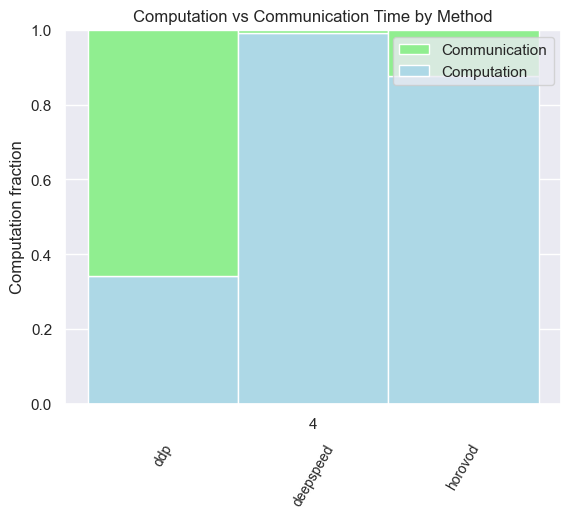

In [22]:
plt.ioff()

# values = np.array([
#     [0.67, 0.53, 0.49, 0.44], # DDP
#     [0.75, 0.62, 0.55, 0.52], # Horovod
#     [0.81, 0.67, 0.58, 0.53], # DeepSpeed
#     # [0.81, 0.67, 0.58, 0.48], # DeepSpeed2
# ])
gpu_numbers = ['4', '8', '16', '32']
strategy_labels = ["DDP" , "Horovod", "DeepSpeed"]#, "DeepSpeed2"]


fig, ax = create_stacked_plot(values, unique_strategies, unique_num_gpus)
plt.show()